# YLearn Case Study - Marketing Promotion

## 1. Summary

...

## 2. Dataset

...

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot  as plt
import warnings

from sklearn.model_selection import train_test_split

from ylearn import Why
from ylearn.uplift import plot_gain, auuc_score

In [2]:
warnings.filterwarnings('ignore')

# pd.set_option('display.max.columns',100)

In [3]:
data = pd.read_csv('data/marketing_promotion.csv.zip')
outcome = 'conversion'

In [4]:
data.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0


In [5]:
data.groupby(['offer', outcome,]).agg([np.size, ])['history'].unstack()

size      
conversion           0     1
offer                       
Buy One Get One  18149  3238
Discount         17413  3894
No Offer         19044  2262

In [6]:
train_data,test_data=train_test_split(data,test_size=0.5,random_state=123)

print('train_data:',train_data.shape)
print('test_data: ',test_data.shape)

train_data: (32000, 9)
test_data:  (32000, 9)


## 3. Causal Effect analysis of BOGO and Discount

### 3.1 Learn Why
Firstly, create an instance of `Why`. Then train the model with `fit()` method, which defines `treatment=’offer’.` The printed logs show the information of identified results and used eatimator. To visualize the causal relations, use `plot_causal_graph()` to obtain the causal graph.

In [7]:
why=Why(estimator='slearner',estimator_options=dict(model='lightgbm'))
why.fit(train_data,outcome,treatment='offer')

09-01 17:32:56 I ylearn.a._why.py 245 - infer outcome as classification
09-01 17:32:56 I ylearn.a._why.py 249 - encode outcome with LabelEncoder
09-01 17:32:56 I ylearn.a._why.py 256 - identify treatment, adjustment, covariate and instrument
09-01 17:32:56 I ylearn.a._why.py 394 - infer discrete_treatment=True
09-01 17:32:56 I ylearn.a._why.py 409 - identified adjustment: None
09-01 17:32:56 I ylearn.a._why.py 410 - identified covariate: ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']
09-01 17:32:56 I ylearn.a._why.py 411 - identified instrument: None
09-01 17:32:56 I ylearn.a._why.py 265 - encode treatment ...
09-01 17:32:56 I ylearn.a._why.py 275 - preprocess data ...
09-01 17:32:57 I ylearn.a._why.py 293 - fit estimator for offer with PermutedSLearner(model=LGBMClassifier(colsample_bytree=0.8, importance_type='gain', max_depth=5,
               n_estimators=50, num_leaves=15, reg_alpha=1, reg_lambda=1,
               subsample=0.5, subsampl

Why(discrete_outcome=True, discrete_treatment=True, estimator='slearner', estimator_options={'model': 'lightgbm'})

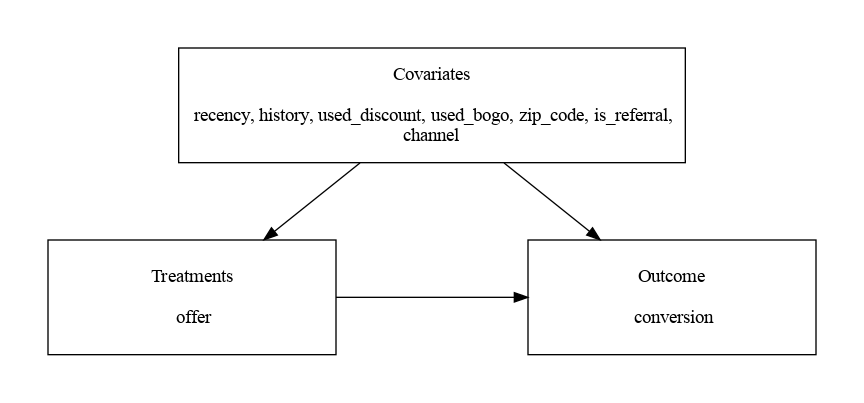

In [8]:
why.plot_causal_graph()

### 3.2 Estimate causal effect

There are four types of card categoties: Blue, Sliver, Gold and Platinum. Taking Blue as control variable and the rest three as treatment variables, method `causal_effect()` outputs three causal effect estimations.  From the results, we find that card upgrade will increase the personal transaction amount. Gold card has the strongest effect.

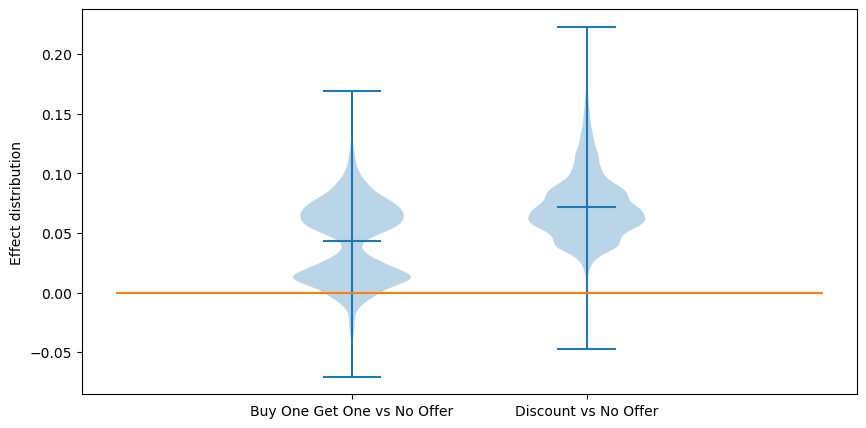

,mean,min,max,std
Buy One Get One vs No Offer,0.042813,-0.070705,0.169431,0.032977
Discount vs No Offer,0.072166,-0.047662,0.222993,0.027897


In [9]:
effect = why.causal_effect(control='No Offer', return_detail=True)
effect = effect.loc['offer'].sort_values(by='mean')
details = effect.pop('detail')

plt.figure(figsize=(10, 5))
plt.violinplot(details.tolist(), showmeans=True)
plt.ylabel('Effect distribution')
plt.xticks(range(1,len(effect)+1), details.index.tolist())
plt.plot( [0, ]*(len(effect)+2) )
plt.show()

effect

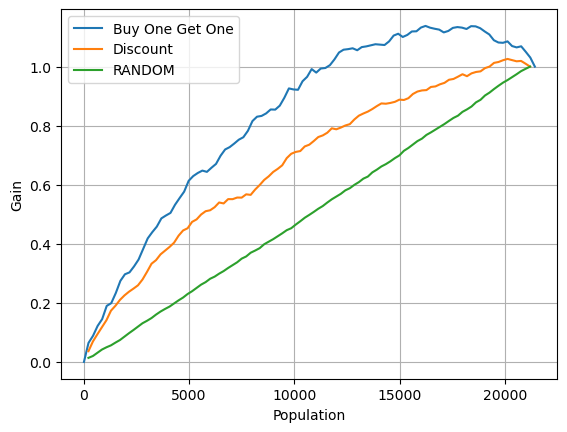

In [10]:
um_bogo =  why.uplift_model(train_data.copy(),treat='Buy One Get One',control='No Offer')
um_discount = why.uplift_model(train_data.copy(),treat='Discount',control='No Offer', random='RANDOM' ) 

plot_gain(um_bogo,um_discount,normalize=True)

In [11]:
pd.concat([um_bogo.auuc_score(),um_discount.auuc_score(),],axis=0)

Buy One Get One    0.830767
Discount           0.670356
dtype: float64

## Comparison of SLearner and TLearner and XLearner



In [12]:
why_s = Why(estimator='slearner',estimator_options=dict(model='lightgbm'))
why_s.fit(train_data,outcome,treatment='offer')

um_s = why_s.uplift_model(train_data.copy(),treat='Buy One Get One',control='No Offer', name='SLearner')

09-01 17:32:59 I ylearn.a._why.py 245 - infer outcome as classification
09-01 17:32:59 I ylearn.a._why.py 249 - encode outcome with LabelEncoder
09-01 17:32:59 I ylearn.a._why.py 256 - identify treatment, adjustment, covariate and instrument
09-01 17:32:59 I ylearn.a._why.py 394 - infer discrete_treatment=True
09-01 17:32:59 I ylearn.a._why.py 409 - identified adjustment: None
09-01 17:32:59 I ylearn.a._why.py 410 - identified covariate: ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']
09-01 17:32:59 I ylearn.a._why.py 411 - identified instrument: None
09-01 17:32:59 I ylearn.a._why.py 265 - encode treatment ...
09-01 17:32:59 I ylearn.a._why.py 275 - preprocess data ...
09-01 17:32:59 I ylearn.a._why.py 293 - fit estimator for offer with PermutedSLearner(model=LGBMClassifier(colsample_bytree=0.8, importance_type='gain', max_depth=5,
               n_estimators=50, num_leaves=15, reg_alpha=1, reg_lambda=1,
               subsample=0.5, subsampl

In [13]:
why_t = Why(estimator='tlearner',estimator_options=dict(model='lightgbm'))
why_t.fit(train_data,outcome,treatment='offer')

um_t = why_t.uplift_model(train_data.copy(),treat='Buy One Get One',control='No Offer', name='TLearner')

09-01 17:32:59 I ylearn.a._why.py 245 - infer outcome as classification
09-01 17:32:59 I ylearn.a._why.py 249 - encode outcome with LabelEncoder
09-01 17:32:59 I ylearn.a._why.py 256 - identify treatment, adjustment, covariate and instrument
09-01 17:32:59 I ylearn.a._why.py 394 - infer discrete_treatment=True
09-01 17:32:59 I ylearn.a._why.py 409 - identified adjustment: None
09-01 17:32:59 I ylearn.a._why.py 410 - identified covariate: ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']
09-01 17:32:59 I ylearn.a._why.py 411 - identified instrument: None
09-01 17:32:59 I ylearn.a._why.py 265 - encode treatment ...
09-01 17:32:59 I ylearn.a._why.py 275 - preprocess data ...
09-01 17:32:59 I ylearn.a._why.py 293 - fit estimator for offer with PermutedTLearner(model=LGBMClassifier(colsample_bytree=0.8, importance_type='gain', max_depth=5,
               n_estimators=50, num_leaves=15, reg_alpha=1, reg_lambda=1,
               subsample=0.5, subsampl

In [14]:
why_x = Why(estimator='xlearner',estimator_options=dict(model='lightgbm'))
why_x.fit(train_data,outcome,treatment='offer')

um_x = why_x.uplift_model(train_data.copy(),treat='Buy One Get One',control='No Offer', name='XLearner', random='RANDOM')

09-01 17:33:00 I ylearn.a._why.py 245 - infer outcome as classification
09-01 17:33:00 I ylearn.a._why.py 249 - encode outcome with LabelEncoder
09-01 17:33:00 I ylearn.a._why.py 256 - identify treatment, adjustment, covariate and instrument
09-01 17:33:00 I ylearn.a._why.py 394 - infer discrete_treatment=True
09-01 17:33:00 I ylearn.a._why.py 409 - identified adjustment: None
09-01 17:33:00 I ylearn.a._why.py 410 - identified covariate: ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel']
09-01 17:33:00 I ylearn.a._why.py 411 - identified instrument: None
09-01 17:33:00 I ylearn.a._why.py 265 - encode treatment ...
09-01 17:33:00 I ylearn.a._why.py 275 - preprocess data ...
09-01 17:33:00 I ylearn.a._why.py 293 - fit estimator for offer with PermutedXLearner(model=LGBMClassifier(colsample_bytree=0.8, importance_type='gain', max_depth=5,
               n_estimators=50, num_leaves=15, reg_alpha=1, reg_lambda=1,
               subsample=0.5, subsampl

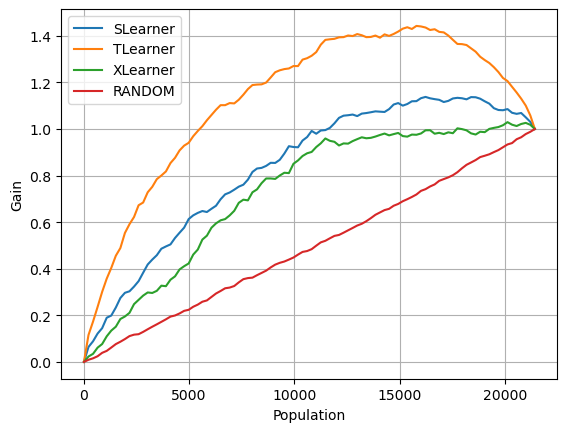

In [15]:
plot_gain(um_s,um_t,um_x,normalize=True)

In [16]:
pd.concat([um_s.auuc_score(),um_t.auuc_score(),um_x.auuc_score()],axis=0)

SLearner    0.830767
TLearner    1.119062
XLearner    0.728834
dtype: float64